In [1]:
import numpy as np
import scipy.integrate as integrate
import pandas as pd

import datetime

from astroquery.jplhorizons import Horizons

import plotly.graph_objects as go

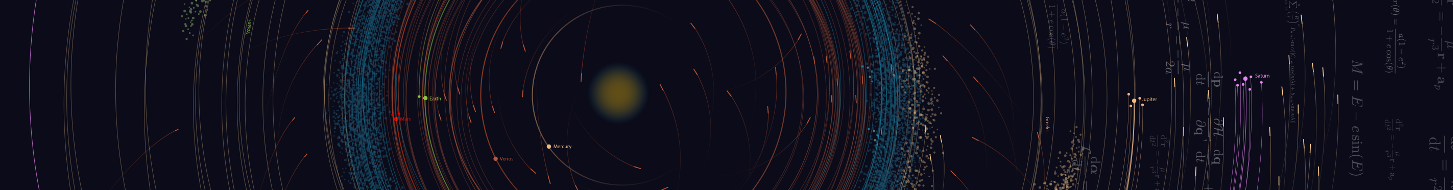

# Project Description
In this project, we simulate a number of large objects from the inner Solar System, accounting for the gravitational dynamics between them. Specifically, we simulate the behavior of Mercury, Mars, Earth, the moon, and Mars over 320 days. 

While our work currently only simulates the inner solar system planets (and our moon), we emphasize the extensibility of our code. Currently, any number of asteroids can be added simply through their NAIF ID, a desired plotting color, and unfortunately their mass (I could not find a nice API for polling mass). An immediate extension of automating color and mass lookup/generation would enable this simulator to simulate thousands of asteroids, similar to the Horizons system.

(Banner image from NASA Horizons homepage.)

# Simulation Setup
### Parameters
We first initialize our simulator with a set of useful constants. This includes the following:
- The values of the universal gravitational constant $G$ and the conversion from one Astronomical Unit to meters.
- Parameters for each solar system body to simulate:
    - Name
    - NAIF ID
    - Color of simulation result plot
    - Color of Horizons reference plot
    - Mass (kg)

In [32]:
## Useful constants
G = 6.6743e-11   # Universal gravitational constant (N * m^2 / kg^2). Source: https://ssd.jpl.nasa.gov/astro_par.html
au = 149597870700 # 1 Astronomical unit in meters: https://cneos.jpl.nasa.gov/glossary/au.html

# Table with parameters for each body
body_names  = ["Sun", "Mercury", "Venus", "Earth", "Moon", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
body_ids    = [10, 199, 299, 399, 301, 499, 599, 699, 799, 899, 999]
body_sim_colors = [
    "lemonchiffon",  # Sun
    "gray",     # Mercury
    "gold",          # Venus
    "lightseagreen", # Earth
    "gray",          # Moon
    "coral",         # Mars
    "orange",        # Jupiter
    "sandybrown",    # Saturn
    "paleturquoise", # Uranus
    "skyblue",       # Neptune
    "gray"           # Pluto
]

body_hrzn_colors = [
    # Colors for plotting horizons data (groundtruth)
    "yellow",       # Sun
    "darkgray",     # Mercury
    "goldenrod",    # Venus
    "darkseagreen", # Earth
    "darkgray",     # Moon
    "darksalmon",   # Mars
    "darkorange",   # Jupiter
    "peru",         # Saturn
    "turquoise",    # Uranus
    "deepskyblue",  # Neptune
    "slategray"     # Pluto
]

body_masses = [
    # Manually retrieved from Horizons:
    1.9891e30,      # Sun
    3.302e23,       # Mercury
    48.685e23,      # Venus
    5.97219e24,     # Earth
    7.349e22,       # Moon
    6.4171e23,      # Mars
    189818722e22,   # Jupiter
    5.6832e26,      # Saturn
    86.813e24,      # Uranus
    102.409e24,     # Neptune
    1.307e22        # Pluto
]

# Create the dataframe with all the planetary information
df_bodies = pd.DataFrame({
    "name": body_names,
    "mass": body_masses,
    "NAIF_ID": body_ids,
    "sim_color": body_sim_colors,
    "hrzn_color": body_hrzn_colors
})

### Select simulation planets
If we simulate all 8 planets + pluto, then it will be hard to see the inner planets and their trajectories. Thus, in most cases we will then ignore the far planets:

In [33]:
# Toggle if we want to only simulate planets within the asteroid belt, before Jupiter
ignore_far_planets = True
if ignore_far_planets:
    # Simply discrad Jupiter and all planets afterward.
    df_bodies = df_bodies.iloc[0:6]

### Horizons API
To validate our simulation against real data, we will use data from the NASA Horizons tool. To ensure a realistic simulation, we will also use this data to seed the starting position and velocity fof our bodies in our simulation.

We access Horizons' data using the Astroquery Horizons module, extract them into Pandas dataframes, and then store them into Numpy arrays.

Here we also define the simulation time range from the start date and the number of simulation days desired. Note that there is a bit of datetime-string manipulation required to then get the correct string for the ending date.

In [119]:
## Pull data from Horizons
# Enter the desired simulation length
start_date = "2023-04-10"
sim_days = 320
sim_steps = int(sim_days/3)

# Create stop time string based on desired simulation length
datetime_format = "%Y-%m-%d"
start_datetime = datetime.datetime.strptime(start_date, datetime_format)
stop_datetime = start_datetime + datetime.timedelta(days=sim_days)
stop_date = stop_datetime.strftime(datetime_format)

def query_body_data(id):
    query = Horizons(id=id, location='500@0', epochs={"start": start_date, "stop": stop_date, "step": str(sim_steps - 1)})
    df = query.vectors().to_pandas()
    hrzns_pos = df[["x", "y", "z"]].to_numpy() * au    # Convert au to m
    hrzns_vel = df[["vx", "vy", "vz"]].to_numpy() * au / (24 * 60 * 60) # Convert au/d to m/s
    return hrzns_pos, hrzns_vel

bodies_pos = np.zeros((len(df_bodies.index), sim_steps, 3))
bodies_vel = np.zeros((len(df_bodies.index), sim_steps, 3))
for i, NAIF_ID in enumerate(df_bodies["NAIF_ID"]):
    pos, vel = query_body_data(NAIF_ID)
    bodies_pos[i, :, :] = pos
    bodies_vel[i, :, :] = vel

# Core Simulation
Now that we have the parameters for each simulation body, we can simulate them using Scipy's `solve_ivp` routine, which by default uses a 4-5th order Runge Khutta, idential to Matlab's `ode45`.

For each body's equation of motion, we simply add the acceleration contribution of each other body together for a total acceleration. or an interaction between two masses named 1 and 2, the force applied from 2 to 1 is thus:

$$F_{12} = m_1 a_1 = \frac{Gm_1m_2}{\lVert r_1 - r_2 \lVert_2 } $$

In [120]:
## Two-body problem
# Handy values for later
n_bodies = len(df_bodies.index)        # Total number of sim bodies
masses = df_bodies["mass"].to_numpy()  # List of all masses

# Pull all initial positions and velocities from the Horizons data we pulled earlier
pos_0 = np.array([])
vel_0 = np.array([])
for i in df_bodies.index:
    pos_0 = np.append(pos_0, bodies_pos[i, 0, :])
    vel_0 = np.append(vel_0, bodies_vel[i, 0, :])

# Y = [x, xdot]
y_0 = np.concatenate([pos_0, vel_0])
    
def sun_earth_diffeq(t, y):
    dy = np.zeros(y.shape)    
    for i in df_bodies.index:
        pos_i = np.atleast_2d(y[3*i: 3*i + 3]).T                  # 3x1 vector: Current body's current position
        pos_all = np.reshape(y[0:n_bodies*3], (n_bodies, 3)).T    # 3xn matrix: Each column is the position of a body
        disp_all = pos_all - pos_i                                # 3xn matrix: Distance from each body to current body (including a zero column for self-self)

        r_all = np.linalg.norm(disp_all, axis=0)                  # 1xn vector: Find distance of each body to current (column norm of disp_all)
        accel_from_each = G * masses * r_all**-3 * disp_all       # 3xn matrix: Law of Universal Gravitation applied to distance to each body
        accel_from_each = np.nan_to_num(accel_from_each)          # 3xn matrix: r_all contained the distance of current body to itself, which is zero, so accel_from_each will have a NaN due to dividing by zero
        accel_i = np.sum(accel_from_each, axis=1)                 # 3x1 vector: Sum all accelerations into the total acceleration of current body

        # Set the acceleration of the current body: d(xdot) = xddot
        dy[3 * (n_bodies + i): 3 * (n_bodies + i + 1)] = accel_i
        
    # Propogate forward the velocities: d(x) = xdot
    dy[0:n_bodies * 3] = y[3*n_bodies:6*n_bodies]
    
    return dy

# Use the simulation timelength we defined when accessing Horizons
n_days = sim_days
tspan = [0, n_days * 24 * 60 * 60]
n_points = sim_steps
t_eval = np.linspace(tspan[0], tspan[1], n_points)

# Simulate the system!
sim_soln = integrate.solve_ivp(sun_earth_diffeq, tspan, y_0, t_eval=t_eval, atol=1e-5, rtol=1e-8)

# Now that we have finished simulating, let's convert all meters to astronomical units for visualization
sim_soln.y = sim_soln.y / au
bodies_pos = bodies_pos / au

/tmp/ipykernel_11521/3698993750.py:24: RuntimeWarning:

divide by zero encountered in power

/tmp/ipykernel_11521/3698993750.py:24: RuntimeWarning:

invalid value encountered in multiply



# Simulation Results

### Full simulation results:
Click on items in the legend to show/hide them. The plot will rescale to adjust. 

While this does not contain planets Jupiter or further, the simulator is fully capable of simulating them. We chose not to simulate them for visibility.

In [121]:
fig = go.Figure()

for i in df_bodies.index:
    body = df_bodies.iloc[i]
    
    # Plot simulator trajectory
    fig.add_trace(go.Scatter3d(
        x=sim_soln.y[3*i, :],
        y=sim_soln.y[3*i+1, :],
        z=sim_soln.y[3*i+2, :],
        name=f"Sim - {body['name']}",
        mode="lines+markers",
        marker={"size": 3, "color": body["sim_color"]}
    ))
    
    # Plot Horizons trajectory
    fig.add_trace(go.Scatter3d(
        x=bodies_pos[i, :, 0],
        y=bodies_pos[i, :, 1],
        z=bodies_pos[i, :, 2],
        name=f"Hrzn - {body['name']}",
        mode="lines+markers",
        marker={"size": 2, "color": body["hrzn_color"], "symbol":"x"}
    ))

fig.update_layout(
    yaxis=dict(scaleanchor="x", scaleratio=1), # Equal x and y scale axes - not necessarily Z!
    scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)"),
    width=1000,
    height=800,
)
fig.show()

The simulation looks generally correct!

### Specific Results

In [122]:
fig = go.Figure()

bodies_to_plot = ["Earth", "Moon"]
df_subselect = df_bodies.iloc[df_bodies["name"].isin(bodies_to_plot).tolist()]

for i in df_subselect.index:
    body = df_bodies.iloc[i]
    
    # Plot simulator trajectory
    fig.add_trace(go.Scatter3d(
        x=sim_soln.y[3*i, :],
        y=sim_soln.y[3*i+1, :],
        z=sim_soln.y[3*i+2, :],
        name=f"Sim - {body['name']}",
        mode="lines+markers",
        marker={"size": 3, "color": body["sim_color"]}
    ))
    
    # Plot horizons trajectory
    fig.add_trace(go.Scatter3d(
        x=bodies_pos[i, :, 0],
        y=bodies_pos[i, :, 1],
        z=bodies_pos[i, :, 2],
        name=f"Hrzn - {body['name']}",
        mode="lines+markers",
        marker={"size": 2, "color": body["hrzn_color"], "symbol":"x"}
    ))

fig.update_layout(
    yaxis=dict(scaleanchor="x", scaleratio=1),
    scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)"),
    width=1000,
    height=800,
)
fig.show()

Note that `x` marks are for Horizons, and dots are for simulation.

Now that we have zoomed in and rescaled, especially on the Z scale, the error in the simulation is made visible. 

### Simulation error
Error over time, comparing our simulation's positions to NASA Horizon's positions

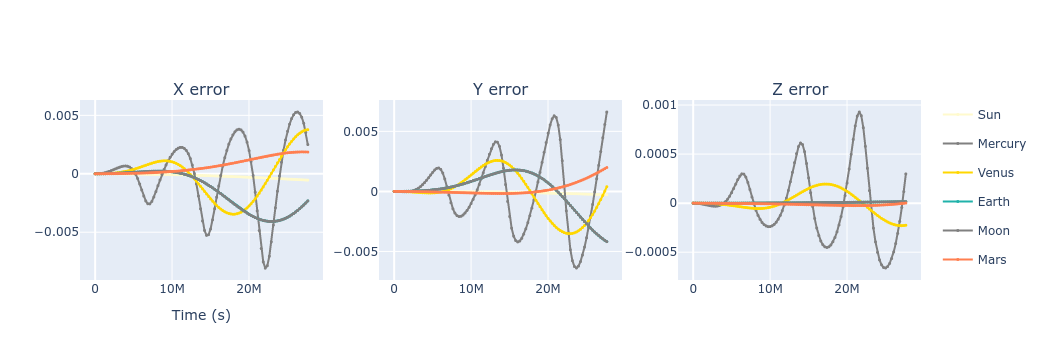

In [123]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=["X error", "Y error", "Z error"])

for i in df_bodies.index:
    body = df_bodies.iloc[i]
    
    # Plot simulator trajectory
    for i_col in [0, 1, 2]:
        fig.add_trace(go.Scatter(
            x=sim_soln.t,
            y=sim_soln.y[3*i + i_col, :] - bodies_pos[i, :, i_col],
            name=f"{body['name']}",
            mode="lines+markers",
            marker={"size": 3, "color": body["sim_color"]},
            legendgroup=body["name"],
            showlegend=True if i_col == 0 else False
        ),row=1, col=i_col+1)

fig.update_layout(xaxis_title="Time (s)")
fig.show()

Generally, our error is below 0.01 astronomical units. 

One interesting observation is that the Earth and Moon position errors appear to be completely identical. This seems to point to a specific bug or omission that is causing the positional error.